In [1]:
import healpy as hp
from luseesky.utils.parse_fits import Beam as luseebeam
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from pyuvdata import uvbeam

## Visualize original beam

In [2]:
path = "../AntennaSimResults/003_Freq1-50MHz_Delta1MHz_AntennaLength6m_AntennaAngle30deg_LanderHeight2m/"
fname = "RadiatedElectricField_AntennaLength6m_AntennaAngle30deg_LanderHeight2m_Phase+0deg.fits"

In [3]:
beam = luseebeam(path + fname)

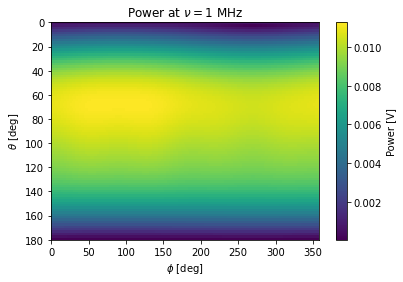

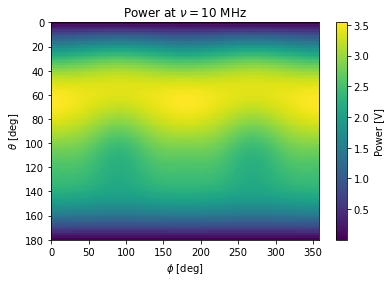

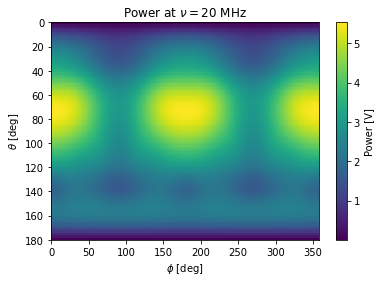

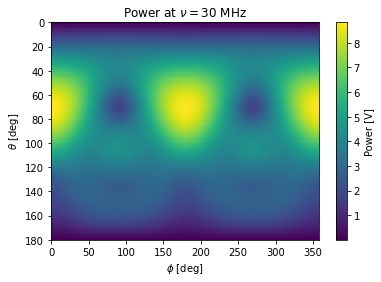

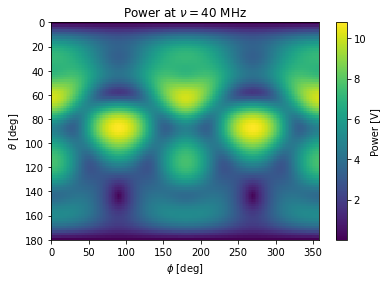

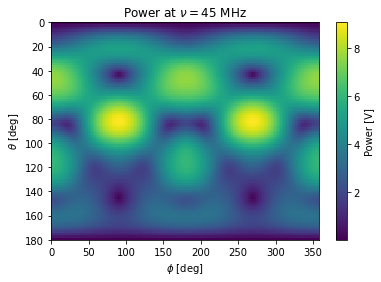

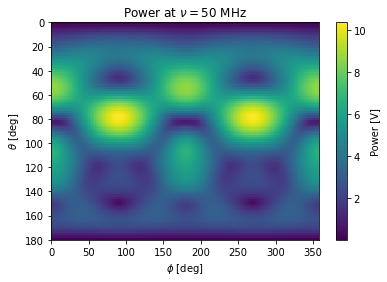

In [4]:
for f in [0, 10, 20, 30, 40, 45, 50]:
    beam.plot_power(f)

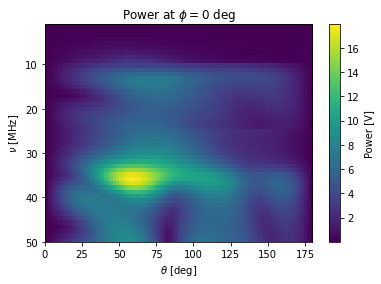

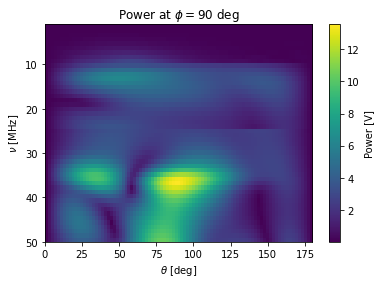

In [5]:
for phi in [0, 90]:
    beam.plot_beamcuts(phi)

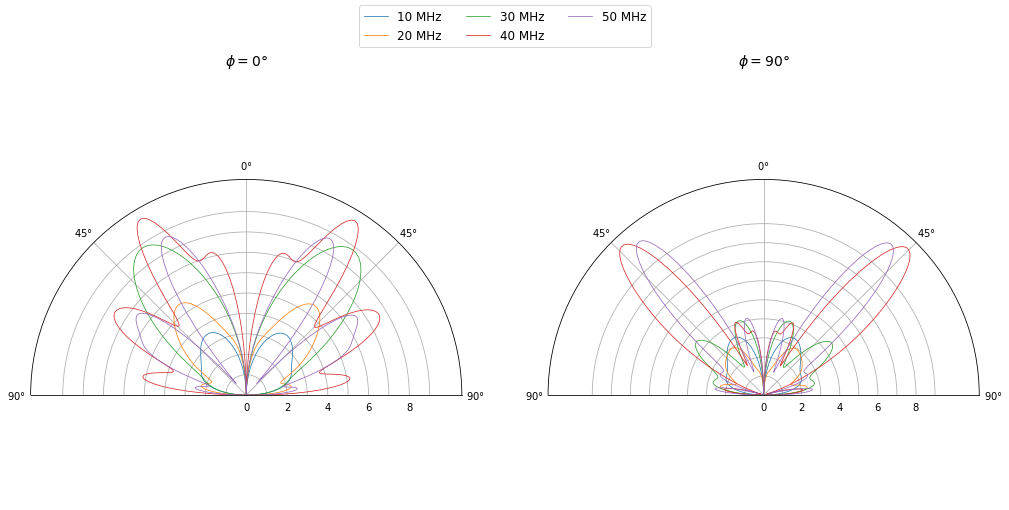

In [6]:
f = beam.frequencies
find_to_plot = [9, 19, 29, 39, 49]
fig, axs = plt.subplots(figsize=(17,8), ncols=2, subplot_kw={'projection': 'polar'})
el = np.deg2rad(np.arange(-91, 91))
gain = beam.power
for j, find in enumerate(find_to_plot):  # loop over the frequencies to plot gain for in each panel
    phi0 = gain[find, :, 0]  # phi = 0
    reverse0 = np.flip(phi0)
    gain0 = np.concatenate((reverse0, phi0))
    axs[0].plot(el, gain0, label='{:d} MHz'.format(int(f[find])), linewidth=0.75)  # phi = 0 
    phi90 = gain[find, :, 45]  # phi = 90
    reverse90 = np.flip(phi90)
    gain90 = np.concatenate((reverse90, phi90))
    axs[1].plot(el, gain90, label='{:d} MHz'.format(int(f[find])), linewidth=0.75)  # phi = 90
plt.setp(axs, theta_zero_location='N')
plt.setp(axs, thetamin=-90, thetamax=90)
handles, labels = axs[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=3, fontsize=12)
for ax in axs:
    ax.set_rgrids([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], ['0', ' ', '2', ' ', '4', ' ', '6', ' ', '8', ' '], angle=22.5)
thetas = [-90, -45, 0, 45, 90]
tticks = [np.deg2rad(t) for t in thetas]
tlabels = [r'${:d} \degree$'.format(int(np.abs(t))) for t in thetas]
plt.setp(axs, xticks=tticks, xticklabels=tlabels)
axs[0].set_title(r'$\phi=0 \degree$', fontsize=14)
axs[1].set_title(r'$\phi=90 \degree$', fontsize=14)
plt.show()

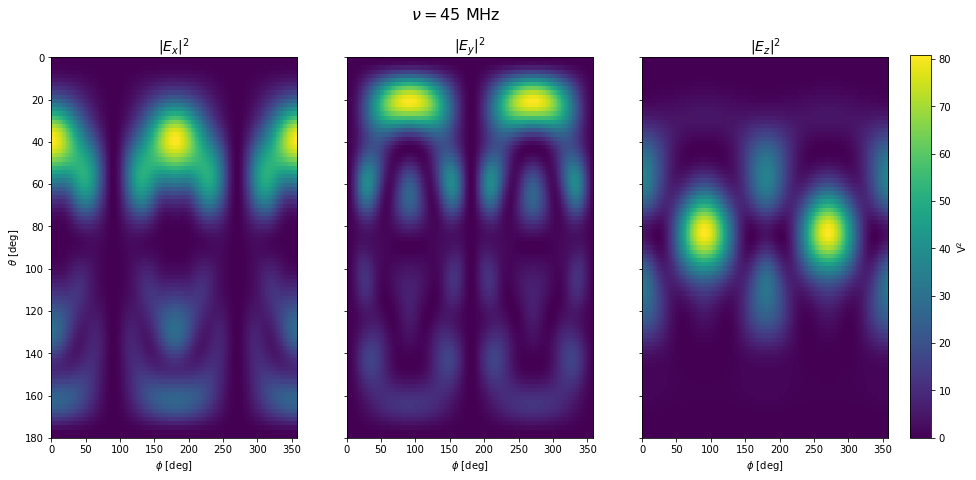

In [7]:
freq = 45
find = np.argmin(np.abs(beam.frequencies - freq))

left, right = beam.phi.min(), beam.phi.max()
top, bottom = beam.theta.min(), beam.theta.max()
extent = [left, right, bottom, top]
components = ["$|E_x|^2$", "$|E_y|^2$", "$|E_z|^2$"]
fig, axs = plt.subplots(figsize=(15,7), ncols=3, sharex=True, sharey=True)
for i, ax in enumerate(axs):
    im = ax.imshow(np.abs(beam.E_field[find, :, :, i])**2, interpolation="none", aspect="auto", extent=extent)
    ax.set_xlabel("$\\phi$ [deg]")
    if i == 0:
        ax.set_ylabel("$\\theta$ [deg]")
    ax.set_title(components[i], fontsize=14)
cax=fig.add_axes([0.92, 0.125, .02, .76])
plt.colorbar(im, cax, label="$\\rm{V}^2$")
plt.suptitle('$\\nu={:.0f}$ MHz'.format(beam.frequencies[find]), fontsize=16)
plt.show()

## Initialize UVBeam object

In [8]:
uvb = beam.to_uvbeam(beam_type="power", verbose=True)

Making UVBeam object from power beam.
Saving 50 files to ./tmp
Deleting files.
Remove directory ./tmp.


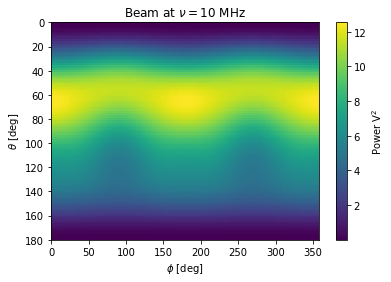

In [9]:
FREQ = 10  # MHz
FREQ *= 1e6  # Hz
FREQ_IND = np.argmin(np.abs(uvb.freq_array[0]-FREQ))

left, right = np.degrees(uvb.axis1_array).min(), np.degrees(uvb.axis1_array).max()
top, bottom = np.degrees(uvb.axis2_array).min(), np.degrees(uvb.axis2_array).max()
plt.figure()
plt.imshow(uvb.data_array[0,0,0,FREQ_IND], interpolation="none", aspect="auto", extent=[left, right, bottom, top])
plt.title('Beam at $\\nu={:.0f}$ MHz'.format(uvb.freq_array[0, FREQ_IND]/1e6))
plt.colorbar(label="Power $\\rm{V}^2$")
plt.xlabel("$\\phi$ [deg]")
plt.ylabel("$\\theta$ [deg]")
plt.show()

In [10]:
# The UVB representation has units of V^2 whereas the original beam has units of V
print(np.allclose(beam.power**2, uvb.data_array[0, 0, 0]))

True


In [11]:
uvb.to_healpix()
uvb.interpolation_function = "healpix_simple"

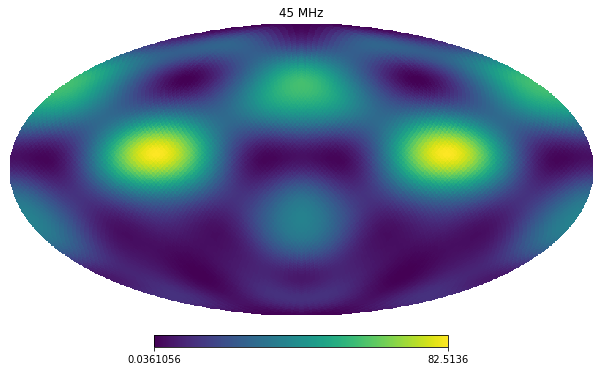

In [12]:
freq = 45e6
find = np.argmin(np.abs(uvb.freq_array[0] - freq))
hp.mollview(uvb.data_array[0, 0, 0, find], title="{:.0f} MHz".format(uvb.freq_array[0, find]/1e6))

In [13]:
uvb_path = "../luseesky/uvbeams/003/"
uvb_fname = fname[:-len(".fits")] + ".uvbeam"

OVERWRITE = True

if OVERWRITE:
    try:
        print("Deleting saved UVBeam.")
        Path(uvb_path + uvb_fname).unlink()
    except (FileNotFoundError):
        pass
    uvb = beam.to_uvbeam(verbose=True)
    print("Saving new UVBeam.")
    uvb.write_beamfits(uvb_path + uvb_fname, clobber=True)
else:
    print("Reading saved UVBeam.")
    uvb = uvbeam.UVBeam()
    uvb.read_beamfits(uvb_path + uvb_fname)

Deleting saved UVBeam.
Making UVBeam object from E-field beam.
Saving new UVBeam.


In [15]:
print(np.allclose(beam.E_field[:, :, :, 0], uvb.data_array[0, 0, 0]))  # E_x and E polarized along x 
print(np.allclose(beam.E_field[:, :, :, 1], uvb.data_array[1, 0, 1]))  # E_y and E polarized along y

True
True
